# Datenpartner mit Anzahl der Objekte pro Bundesland

Dieses Notebook ruft Statistiken aus der API der Deutschen Digitalen Bibliothek ab und bereitet sie für eine Auswertung nach Bundesland auf.

In [1]:
import requests
import pandas as pd
from datetime import datetime
from IPython.display import Markdown, display

# Zuerst wird aus der DDB-Suche eine Facet-Statistik zu `dataprovider_id` geladen. 
# Ergebnis dieser Zelle ist `df` mit zwei Spalten (`dataprovider_id`, `count`). 
# Zusätzlich wird auf 32-stellige Provider-IDs gefiltert, damit im DataFrame nur echte Provider-IDs stehen.

# API-Call: https://api.deutsche-digitale-bibliothek.de/2/search/index/search/select?q=*%3A*&rows=0&facet=true&facet.field=dataprovider_id&facet.limit=-1&facet.sort=count&wt=json

url = "https://api.deutsche-digitale-bibliothek.de/2/search/index/search/select"
params = {
    "q": "*:*",
    "rows": 0,
    "facet": "true",
    "facet.field": "dataprovider_id",
    "facet.limit": -1,
    "facet.sort": "count",
    "wt": "json",
}

resp = requests.get(url, params=params, timeout=300)
resp.raise_for_status()
data = resp.json()

facet_list = data["facet_counts"]["facet_fields"]["dataprovider_id"]  # ["id1", count1, "id2", count2, ...]
pairs = list(zip(facet_list[0::2], facet_list[1::2]))

df = pd.DataFrame(pairs, columns=["dataprovider_id", "count"])
df["dataprovider_id"] = df["dataprovider_id"].astype(str)
df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0).astype("int64")

df = df[df["dataprovider_id"].str.len() == 32].reset_index(drop=True)
# df

# Als nächstes werden Organisationsdaten (Einrichtungen und Aggregatoren) aus dem Organisation-Index geladen. 
# Felder, die mal als Liste und mal als Einzelwert kommen, werden vereinheitlicht. 
# Ergebnis ist `df_org` mit Metadaten wie `label`, `type`, `sector_fct`, `city_de_fct` und `state_de_fct`.
# 
# API-Call: https://api.deutsche-digitale-bibliothek.de/2/search/index/organization/select?q=type:ddb-institution%20OR%20type:ddb-aggregator&fl=id,label,type,sector_fct,city_de_fct,state_de_fct&rows=10000&wt=json

url_org = "https://api.deutsche-digitale-bibliothek.de/2/search/index/organization/select"
params_org = {
    "q": "type:ddb-institution OR type:ddb-aggregator",
    "fl": "id,label,type,sector_fct,city_de_fct,state_de_fct",
    "rows": 10000,
    "wt": "json",
}

resp_org = requests.get(url_org, params=params_org, timeout=300)
resp_org.raise_for_status()
data_org = resp_org.json()

docs = data_org.get("response", {}).get("docs", [])

def _as_list(value):
    if value is None:
        return []
    # Solr liefert bei *_fct i.d.R. Listen; zur Sicherheit wird auch ein Scalar zu einer Liste normalisiert
    return value if isinstance(value, list) else [value]

df_org = pd.DataFrame({
    "id": [d.get("id") for d in docs],
    "label": [_as_list(d.get("label")) for d in docs],
    "type": [d.get("type") for d in docs],
    "sector_fct":  [d.get("sector_fct") for d in docs],
    "city_de_fct": [_as_list(d.get("city_de_fct")) for d in docs],
    "state_de_fct": [_as_list(d.get("state_de_fct")) for d in docs],
})
# df_org

# Anschließend werden die Provider-Statistik (`df`) und die Organisationsdaten (`df_org`) zusammengeführt.
# Damit stehen pro Einrichtung/Provider sowohl Metadaten als auch die Objektanzahl (`count`) zur Verfügung.
# Das Ergebnis kann als Excel-Datei mit aktuellem Datum gespeichert werden (`df_join`).

# Join: Provider-Facets (df) + Organisationsdaten (df_org)
df_org["id"] = df_org["id"].astype(str)

df_join = df.merge(df_org, left_on="dataprovider_id", right_on="id", how="outer")

# Für Excel: Array-Spalten lesbar als Strings serialisieren (Listen -> '; '-String)
for col in ["label", "city_de_fct", "state_de_fct"]:
    if col in df_join.columns:
        df_join[col] = df_join[col].apply(lambda xs: "; ".join(map(str, xs)) if isinstance(xs, list) else ("" if xs is None else str(xs)))

# Optional: doppelte Join-Spalte entfernen und Spaltenordnung setzen
if "dataprovider_id" in df_join.columns:
    df_join = df_join.drop(columns=["dataprovider_id"])

df_join = df_join[["id", "label", "type", "sector_fct", "city_de_fct", "state_de_fct", "count"]]

# Ergebnis in Excel-Datei speichern mit Datum
# out_path = "statistic-federal_state_" + pd.Timestamp.now().strftime("%Y-%m-%d") + ".xlsx"
# df_join.to_excel(out_path, index=False)

# df_join

# Im nächsten Schritt wird `df_join` nach Bundesland ausgewertet. Dafür wird das (ggf. mehrfach belegte)
# Bundeslandfeld auf einen Wert reduziert und anschließend je Bundesland aggregiert:
# - Anzahl eindeutiger Einrichtungen
# - Anzahl liefernder Einrichtungen (`count > 0`)
# - Summe der Objekte (`count`)
# 
# Ergebnis ist der DataFrame `agg`.

df_bl = df_join.loc[df_join["id"].notna(), ["id", "state_de_fct", "count"]].copy()
df_bl["count"] = pd.to_numeric(df_bl["count"], errors="coerce").fillna(0).astype("int64")

# state_de_fct ist nach dem Join serialisiert ("; "-getrennt). Für die Zuordnung wird der erste Wert verwendet.
df_bl["Bundesland"] = (
    df_bl["state_de_fct"]
    .fillna("")
    .astype(str)
    .str.split("; ")
    .str[0]
    .str.strip()
    .replace({"": "Ausland"})
)

einrichtungen = df_bl.groupby("Bundesland")["id"].nunique().rename("Einrichtungen")
liefernde = (
    df_bl.loc[df_bl["count"] > 0]
    .groupby("Bundesland")["id"]
    .nunique()
    .rename("Liefernde Einrichtungen")
)
objekte = df_bl.groupby("Bundesland")["count"].sum().rename("Objekte")

agg = (
    pd.concat([einrichtungen, liefernde, objekte], axis=1)
    .fillna(0)
    .astype({"Einrichtungen": "int64", "Liefernde Einrichtungen": "int64", "Objekte": "int64"})
    .sort_values(["Objekte", "Liefernde Einrichtungen", "Einrichtungen"], ascending=False)
)

# Stand: Datum/Uhrzeit der Notebook-Ausführung (lokale Zeitzone)
stand = datetime.now().astimezone().strftime("%d.%m.%Y um %H:%M:%S Uhr")
display(Markdown(f"**Letzte Aktualisierung:** {stand}"))

# Anzeige
agg

**Letzte Aktualisierung:** 12.02.2026 um 05:04:00 Uhr

,Einrichtungen,Liefernde Einrichtungen,Objekte
Bundesland,,,
Baden-Württemberg,589,57,11004229
Hessen,382,57,9878446
Nordrhein-Westfalen,883,157,9332725
Sachsen,385,54,7070368
Bayern,600,58,6390424
Berlin,304,108,5186689
Rheinland-Pfalz,165,29,4553607
Sachsen-Anhalt,144,21,1972997
Schleswig-Holstein,337,43,1774401


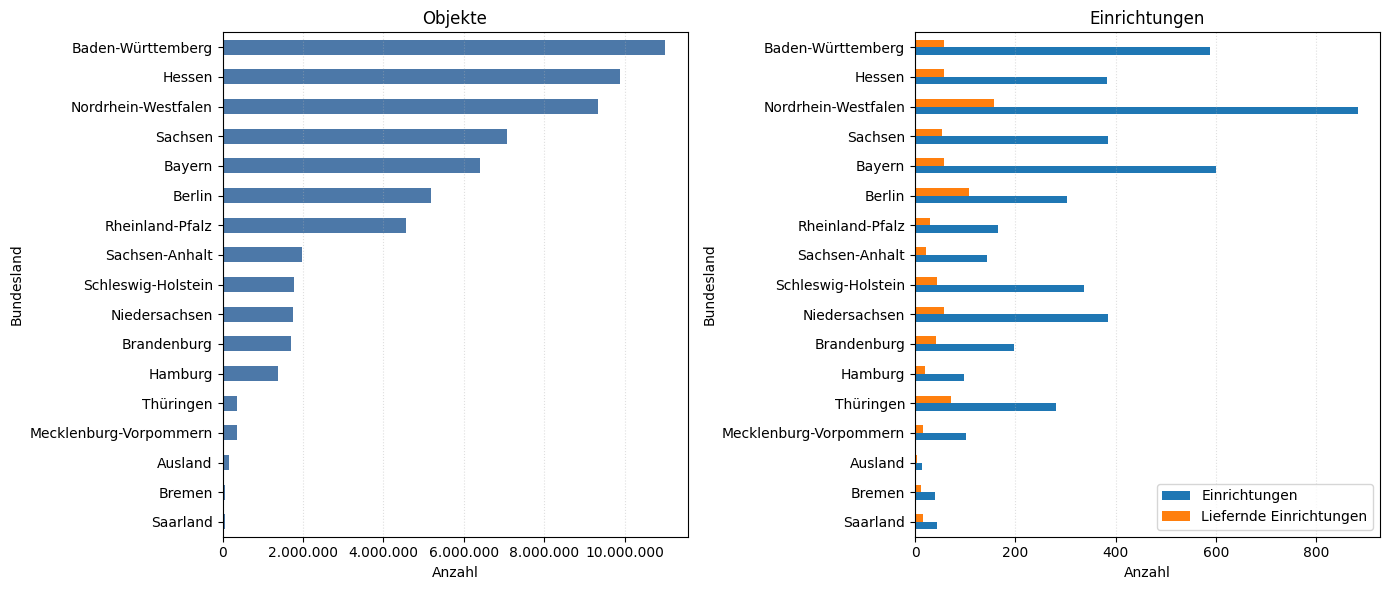

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Zum Schluss werden die aggregierten Werte aus `agg` als horizontale Balkendiagramme dargestellt:
# - Objekte je Bundesland
# - Einrichtungen vs. liefernde Einrichtungen je Bundesland
# Die Achsenbeschriftung wird so formatiert, dass große Zahlen ohne wissenschaftliche Notation gut lesbar bleiben.

plot_df = agg.iloc[::-1]  # für barh: klein -> groß

fig, axes = plt.subplots(1, 2, figsize=(14, max(6, 0.35 * len(plot_df))))

def _format_int_no_sci(x, pos):
    _ = pos  # required by FuncFormatter signature
    return f"{x:,.0f}".replace(",", ".")

# Objekte
plot_df["Objekte"].plot(kind="barh", ax=axes[0], color="#4C78A8")
axes[0].set_title("Objekte")
axes[0].set_xlabel("Anzahl")
axes[0].grid(axis="x", linestyle=":", alpha=0.4)
axes[0].xaxis.set_major_formatter(FuncFormatter(_format_int_no_sci))

plot_df[["Einrichtungen", "Liefernde Einrichtungen"]].plot(kind="barh", ax=axes[1])
axes[1].set_title("Einrichtungen")
axes[1].set_xlabel("Anzahl")
axes[1].grid(axis="x", linestyle=":", alpha=0.4)
axes[1].legend(loc="lower right")

fig.tight_layout()
plt.show()